# Example 02: Cleaning Data with ICA - Part 1

## Imports

Here we import needed libraries and get the dataset from Kaggle.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import numpy as np

from notebooks.feature_extraction import get_autoregression_features

plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

np.random.seed(42)

def read_kaggle_json(filepath):
    filepath = os.path.expanduser(filepath)
    username = None
    token = None
    with open(filepath, "r") as file:
        config = json.load(file)
        username = config.get("username")
        token = config.get("key")
    return username, token


kaggle_json_filepath = "/workspaces/fall-2024-class-08/kaggle/kaggle.json"
kaggle_username, kaggle_api_token = read_kaggle_json(kaggle_json_filepath)

if kaggle_username and kaggle_api_token:
    os.environ["KAGGLE_USERNAME"] = kaggle_username
    os.environ["KAGGLE_KEY"] = kaggle_api_token

import kaggle

dataset_name = "andrewmvd/sp-500-stocks"
download_location = "/workspaces/fall-2024-class-08/downloads"

kaggle.api.authenticate()
kaggle.api.dataset_download_files(
    dataset_name, path=download_location, unzip=True
)

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks


## Get the Dataset

In [2]:
stocks_file_path = "/workspaces/fall-2024-class-08/downloads/sp500_stocks.csv"
index_file_path = "/workspaces/fall-2024-class-08/downloads/sp500_index.csv"
companies_file_path = (
    "/workspaces/fall-2024-class-08/downloads/sp500_companies.csv"
)

stocks_df = pd.read_csv(stocks_file_path)
index_df = pd.read_csv(index_file_path)
companies_df = pd.read_csv(companies_file_path)
dates = stocks_df["Date"].unique()

## Build an Auto-regression Matrix

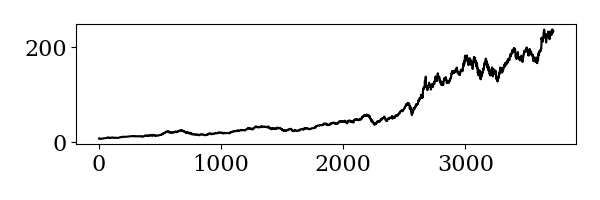

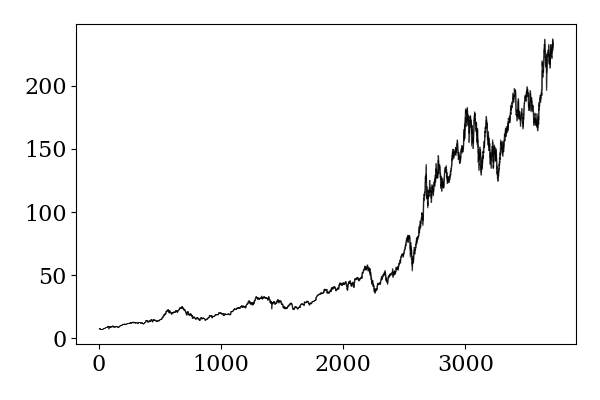

In [3]:
# Specify the target symbol to predict, number of days of history to use in the
# autoregressive model, and number of days forward to predict.
# Increasing the history (to 20, 50, etc.) will increase the smoothness.
n_days_history = 10
n_days_forward = 1

# Get the dataset
x_features_aapl = get_autoregression_features(
    dates,
    stocks_df,
    n_days_history,
    n_days_forward,
    predictor_symbols=["AAPL"],
)

plt.figure(figsize=(6, 2))
plt.plot(x_features_aapl[:, -1], color="k")
plt.tight_layout()

plt.figure(figsize=(6, 4))
plt.plot(x_features_aapl, color="k", linewidth=0.1, alpha=0.75)
plt.tight_layout()

## ICA Imports

In [4]:
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler

## Run FastICA

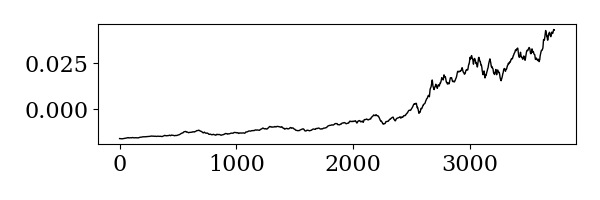

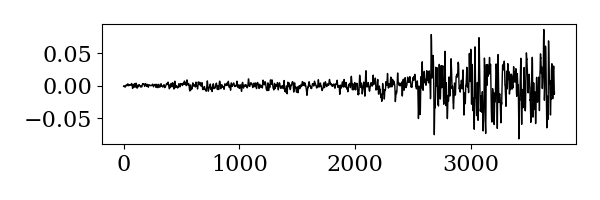

In [5]:
# Remove NaNs
x_features_aapl[np.isnan(x_features_aapl)] = 0

scaler = StandardScaler()
x_features_scaled = scaler.fit_transform(x_features_aapl)

ica = FastICA(
    n_components=2,
    whiten="arbitrary-variance",
    tol=1e-10,
    max_iter=500,
    random_state=42,
)
x_features_transformed = ica.fit_transform(x_features_scaled)

for idx in range(x_features_transformed.shape[1]):
    plt.figure(figsize=(6, 2))
    plt.plot(x_features_transformed[:, idx], color="k", linewidth=1)
    plt.tight_layout()

## Reconstruct the Data without the Noise

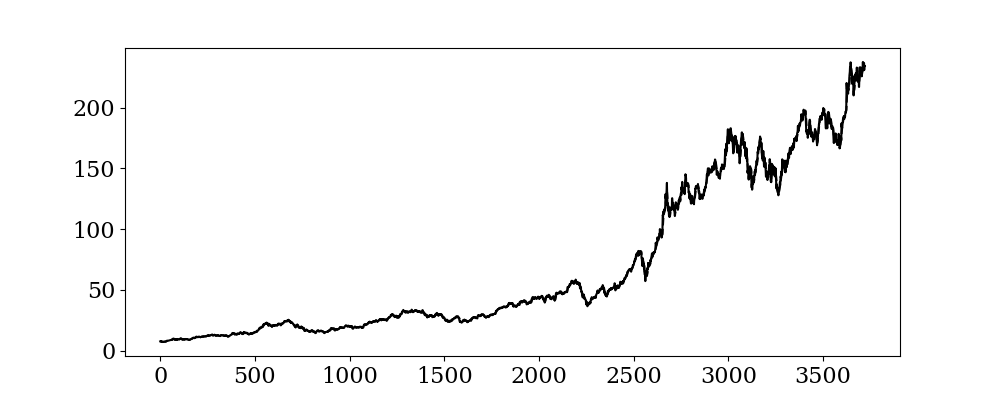

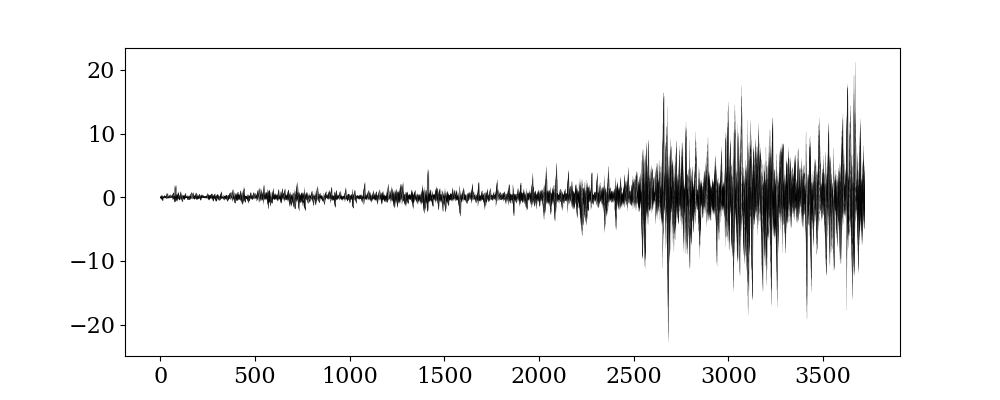

In [6]:
noise_idx = 1
x_features_transformed[:, noise_idx] = 0

x_features_reconstructed = ica.inverse_transform(x_features_transformed)
x_smooth_original_scale = scaler.inverse_transform(x_features_reconstructed)

delta = x_smooth_original_scale - x_features_aapl

plt.figure(figsize=(10, 4))
_ = plt.plot(
    x_smooth_original_scale[:, -1], color="k", linestyle="--", label="Smoothed"
)
_ = plt.plot(x_features_aapl[:, -1], color="k", label="Original")

plt.figure(figsize=(10, 4))
_ = plt.plot(delta, color="k", linewidth=0.1, alpha=0.75)